# PIT - Práctica 1: Análisis de Series Temporales - Modelos Clásicos

**Alicia Lozano Díez**
 
13 de febrero de 2023


## Objetivo

El objetivo de esta práctica es proporcionar una introducción al procesamiento y análisis de señales temporales: descomposición de una serie temporal para el estudio de sus propiedades, ajuste de modelos lineales (ARIMA) y predicción.

### Materiales - Moodle

- Guión (.ipynb) de la práctica
- Datos (.csv): bases de datos _AirPassengers.csv_ y _stocks_1yr.csv_.


# 1. Introducción al procesamiento de señales temporales: Air Passengers

## 1.1. Cargar los datos en Google Colab y manejo de los datos en Python

Primero vamos a descargar el fichero con los datos de la base de datos *AirPassengers.csv* de Moodle, que contiene los datos del número de pasajeros de una aerolínea para un periodo de tiempo.

Las siguientes líneas de código nos permitirán subir el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers.csv


A continuación, vamos a leer el fichero *AirPassengers.csv* en Python, con la ayuda de la librería *pandas*.

Lo cargaremos haciendo uso también del módulo de Python *datetime* para operar con este tipo de datos de forma cómoda.

La función definida *parser* nos permitirá cambiar el formato de fecha/tiempo al formato que esperamos encontrar en nuestra base de datos.

In [ ]:
from pandas import read_csv
from datetime import datetime
 
def parser(x):
	return datetime.strptime(x, '%Y-%m')
 
data = read_csv('AirPassengers.csv', header=0, parse_dates=[0], index_col=0, 
                squeeze=True, date_parser=parser)
print(data.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


Podemos visualizar cómo está indexada la estructura de datos, así como el número de datos que tiene nuestra serie temporal.

In [ ]:
data.index


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Si queremos acceder a un dato en concreto, por ejemplo, el número de pasajeros del mes de marzo de 1949, podemos hacerlo de la siguiente forma:

In [ ]:
data['1949-03-01']


132

O de esta otra:

In [ ]:
data[datetime(1949,3,1)]

132

## 1.2. Representación de los datos


El primer paso para analizar una serie temporal es obtener una representación de los datos, para poder hacernos una idea de las características de la serie de forma visual. 

Para ello, podemos utilizar la librería *matplotlib* como sigue:

Text(0.5, 1.0, 'Serie temporal: Air Passengers')

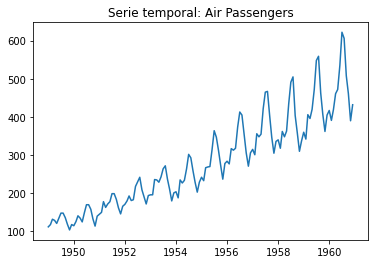

In [ ]:
from matplotlib import pyplot as plt
plt.plot(data)
plt.title('Serie temporal: Air Passengers')

## 1.3. Estudio de la estacionariedad de la serie


Algunos de los modelos de análisis de series temporales asumen estacionariedad en las series. Por ello, vamos a ver dos métodos para comprobar si una serie es estacionaria.

Uno de ellos es un análisis más visual: calculamos la media y desviación estándar "móviles" (con una ventana deslizante). 

In [ ]:
import pandas as pd

def test_stationarity_1(timeseries,window_size):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

El segundo método consiste en el test estadístico Dickey-Fuller:

In [ ]:
import pandas as pd

from statsmodels.tsa.stattools import adfuller
def test_stationarity_2(timeseries):    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
def test_stationarity(timeseries,window_size):
  test_stationarity_1(timeseries,window_size)
  test_stationarity_2(timeseries)

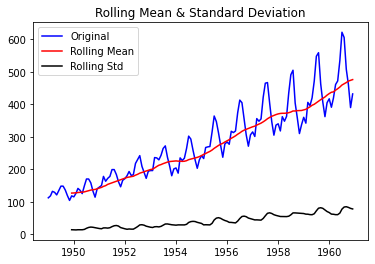

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
test_stationarity(data,12)

**PREGUNTAS**

1.   ¿Qué conclusiones puede extraer del análisis de estacionariedad de la serie original?
2.   ¿Qué diferencias observas al variar el tamaño de la ventana para hacer las medias móviles? Prueba con un par de tamaños, incluye las gráficas obtenidas y explica las diferencias visuales que aprecias.

**RESPUESTA**:
1. Podemos concluir que esta serie no es estacionaria porque obtenenmos un p-valor de 0.991880, por ello, rechazamos la hipótesis de estacionariedad. Además, también se puede ver de manera gráfica que la serie no es estacionaria, pues tiene pendiente no nula.
2. En primer lugar, podemos confirmar que el Dickey-Fuller test da el mismo resultado, pues este no depende del tamaño de la ventana. Por otro lado, se han representado las gráficas obtenidas para los tamaños de ventana 4, 12 y 24. En estos, se puede observar como cuanto más pequeño es el tamaño de la ventana, la varianza de la media móvil será mayor; mientras que si el tamaño de la ventana es muy grande, la media móvil será la media de más valores de la serie, obteniéndose así una menor varianza. Es por ello que es recomendable tener una idea de la estacionalidad de la serie (representándola de manera gráfica) para fijar el tamaño de la ventana. En este caso, como tenemos una estacionalidad de 12 unidades (12 meses), es recomendable hacer uso de una ventana de 12 unidades. 

Tamaño de ventana 4


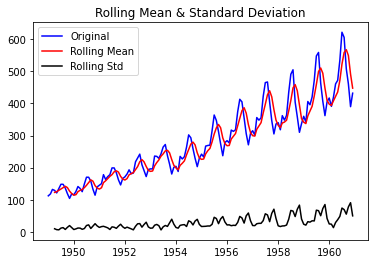

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Tamaño de ventana 12


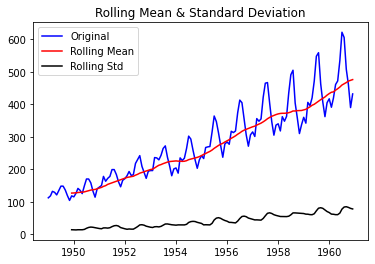

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Tamaño de ventana 24


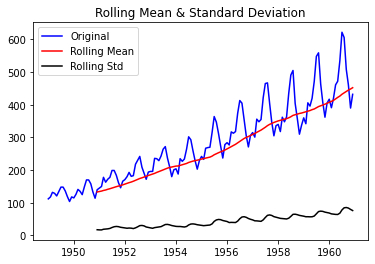

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
for item in (4, 12, 24):
  print("Tamaño de ventana", item)
  test_stationarity(data,item)

## 1.4. Transformar una serie temporal en estacionaria

Como hemos visto en la teoría, para analizar la serie y poder ajustarle un modelo tipo AR, MA o ARMA, esperamos que la serie a modelar sea estacionaria. 

Para conseguir una serie lo más estacionaria posible, podemos aplicar distintas transformaciones de la serie original. Vamos a ver algunos ejemplos:

a) *Transformaciones simples para reducir el efecto de la tendendia*:

En el caso de los datos del ejemplo, la tendencia es positiva, por lo que podemos aplicar alguna transformación que penalice los valores más altos y menos los más bajos. Es el caso del logaritmo, la raíz cuadrada, etc. 

**PREGUNTA**


1.   Representa a continuación la serie aplicándole una transformación logarítmica. ¿Qué observas?



**RESPUESTA**

Text(0.5, 1.0, 'Serie temporal logarítmica: Air Passengers')

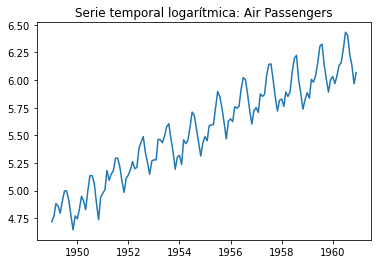

In [ ]:
import numpy as np

data_log = np.log(data)

plt.plot(data_log)
plt.title("Serie temporal logarítmica: Air Passengers")

Podemos observar que, tras aplicar el logartimo, se dan menos importancia a los picos correspondientes a los meses en los que más pasajeros viajan y los que viajan menos pasajeros, y se da más importancia a la media de pasajeros anual, haciendo que esta media crezca con mayor suavidad. Además, en lugar de estar en una escala donde los valores se miden en centenas, pasamos a las unidades.

En casos más complejos en los que la tendencia no se ve clara (sobre todo en presencia de ruido), se pueden aplicar otros métodos. Uno de ellos es el suavizado como las medias móviles (*moving average*). 

Por ejemplo, podemos aplicar un suavizado con una media con ventana deslizante que tenga en cuenta un año (12 meses). 
Ten en cuenta, que esto implicará que para calcular la media de las primeras muestras, no tengo suficientes datos para la ventana. Esto lo podemos ver en la salida de la media móvil (tendremos que eliminar los *NaN* que aparecen).


**PREGUNTAS**


1.   Aplica dicha media móvil y represéntala junto a los datos. Puede utilizar los datos en escala logarítmica. ¿Esta media móvil representa claramente la tendencia de la serie?

2.   Elimina ahora de la serie original (transformada con el logaritmo si es como la has calculado previamente) la influencia de esta media móvil y representa el resultado. ¿Qué observas ahora?

3.   Realiza el test de estacionariedad de la serie resultante y compáralo con el de la serie original. ¿Qué conclusiones puedes obtener tanto del test visual como del test estadístico?






**RESPUESTA**

In [ ]:
def test_stationarity_1_log(timeseries,window_size):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

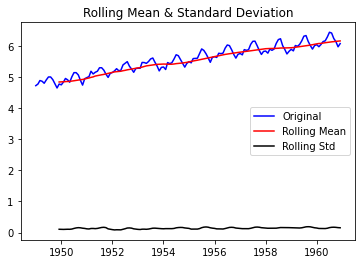

In [ ]:
test_stationarity_1_log(data_log,12)

1. Esta media móvil sí que representa la tendencia de la serie; pese a que la magnitud de los datos sea menor, se obtiene un resultado idéntico a lo obtenido previamente, aunque más suavizado y con una menor desviación típica.

In [ ]:
def test_stationarity_1_log_wo_ma(timeseries,window_size):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries-rolmean, color='blue',label='Original')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Hacemos la representación de la serie normal sin la media:

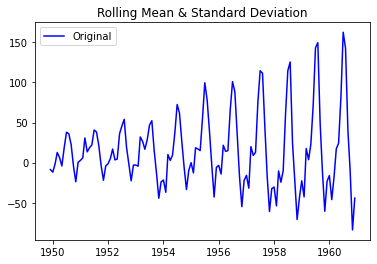

In [ ]:
test_stationarity_1_log_wo_ma(data,12)

También representamos la serie en escala logarítmica sin la media:

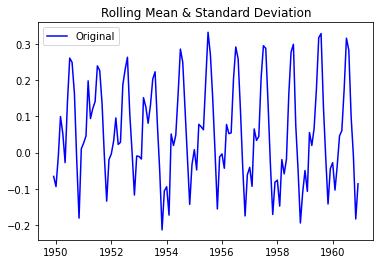

In [ ]:
test_stationarity_1_log_wo_ma(data_log,12)

2. En este caso, hemos representado la serie en escala normal y le hemos restado la media. De esta manera, se quita la influencia de la misma para poder estudiar con mayor claridad la estacionalidad. También se ha representado la serie en escala logarítmica tras restarle la media, y se puede ver como a la hora de estudiar los picos correspondientes a la estacionalidad, se les da a todos una importancia idéntica. Esto se debe a que se ha suavizado el comportamiento de la serie. 
De todas formas, la estacionalidad se observa con mayor claridad en la primera figura.

En primer lugar, realizamos el test a la serie con escala normal:

In [ ]:
rolmean = data.rolling(window=12).mean().dropna()
test_stationarity_2(data.subtract(rolmean, fill_value=0))

Results of Dickey-Fuller Test:
Test Statistic                  -5.202055
p-value                          0.000009
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Ahora, lo realizamos a la serie con escala logarítmica:


In [ ]:
rolmean = data_log.rolling(window=12).mean().dropna()
test_stationarity_2(data_log.subtract(rolmean, fill_value=0))

Results of Dickey-Fuller Test:
Test Statistic                  -4.996649
p-value                          0.000023
#Lags Used                       5.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64


3. En ambos casos, se obtiene un p-valor muy pequeño, por lo que podemos confirmar que ambas series son estacionarias. De hecho, esto también se puede observar de manera gráfica en las dos representaciones anteriores. 

b) *Diferenciar (derivar)*:

Las técnicas anteriores son sencillas y pueden eliminar parte de la influencia de la tendencia de la serie, pero no suelen ser suficientes cuando se tiene por ejemplo estacionalidad. 

Diferenciar (o derivar) es uno de los métodos más comunes para eliminar la influencia de la tendencia y la estacionalidad en la serie original, mejorando las propiedades de estacionariedad de la serie. 

Podemos tomar la derivada de orden uno de la siguiente manera (partimos de la serie en el dominio logarítmico): 

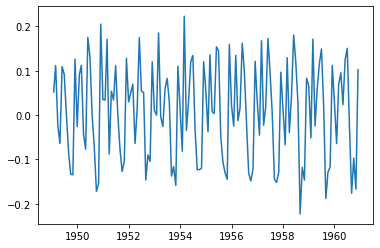

In [ ]:
data_log_diff = (data_log - data_log.shift()).dropna()
plt.plot(data_log_diff)

**PREGUNTAS**


1.   ¿Qué observas en la serie resultante?
2.   ¿Es esta serie estacionaria de acuerdo a los criterios anteriores? Incluye los resultados gráficos y del test estadístico e interprétalos.
3. Repite el proceso para una segunda derivada. ¿Qué observas ahora?



**RESPUESTA**
1. En la serie resultante, como se ha empleado la derivada, se ha podido eliminar la tendencia, haciendo que la media de la serie resultante esté centrada en el origen. 

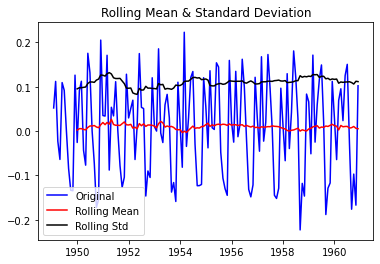

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
test_stationarity(data_log_diff, window_size = 12)

2. El p-valor obtenido es muy pequeño, por lo que podemos confirmar que es estacionaria con una confianza superior al 90%.

3. Repetimos el proceso para la segunda derivada:

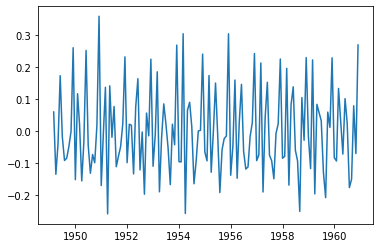

In [ ]:
data_log_diff2 = (data_log_diff - data_log_diff.shift()).dropna()
plt.plot(data_log_diff2)

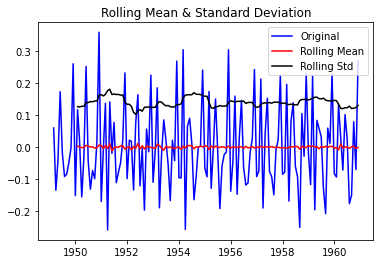

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [ ]:
test_stationarity(data_log_diff2, window_size = 12)

En este caso, se puede observar como tras aplicar la segunda derivada, hemos obtenido un p valor mucho menor al anterior, así podemos confirmar con una confianza mayor que el resultado obtenido es no estacionario.

c) *Descomposición de la serie*:

La mayoría de series pueden descomponerse en tendencia, estacionalidad y residuo, como hemos visto en clase. 

Utilizando la función *seasonal_decompose* del módulo de Python *statsmodels* podemos obtener estas tres componentes y por tanto, modelarlas por separado: 

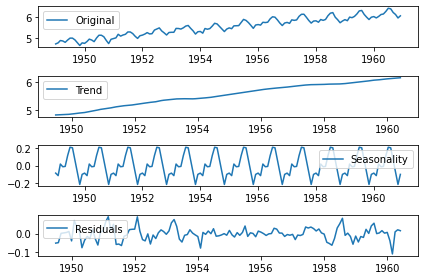

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**PREGUNTAS**

1.   ¿Es la señal residual estacionaria? Realiza el test y comenta los resultados.



In [ ]:
test_stationarity_2(residual.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


El p-valor obtenido es muy bajo, por lo que podemos confirmar que la señal residual es estacionaria. De hecho, tal y como indican los apuntes, esta suele ser estacionaria.

## 1.5. Modelado ARIMA y predicción

Uno de los modelos clásicos para series temporales vistos en clase es el modelo ARIMA, que permite derivar *d* veces, y aplicar *p* coeficientes autorregresivos (AR) y *q* términos de error (shocks, provenientes de la parte MA) en la combinación lineal.  

Para determinar el valor de los parámetros *p* y *q*, podemos hacer uso de las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). 

Si calculamos dichas funciones para la serie derivada previamente, obtenemos lo siguiente:

In [ ]:
#!pip install -U statsmodels

Text(0.5, 1.0, 'Partial Autocorrelation Function')

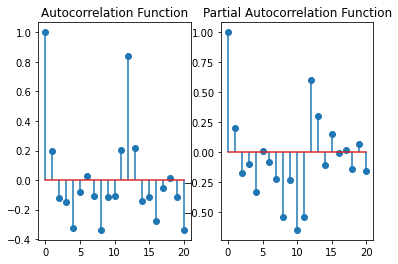

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(data_log_diff, nlags=20, fft=False)
lag_pacf = pacf(data_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.title('Partial Autocorrelation Function')

Podemos añadir además un intervalo de confianza a ambos lados del valor cero, de tal manera que el primer valor de retardo que cruce ese intervalo por arriba en la función de PACF será el valor de *p*, y de ACF, será *q*.

Para los niveles de confianza estándar, el valor del límite del intervalo de confianza al 95% es 1.96. Suponiendo desviación estándar unidad, el límite estaría en (-1.96/sqrt(N), 1.96/sqrt(N)), donde N es el número de puntos. 

Si incluimos estos límites en la figura anterior, podemos obtener una buena aproximación de los valores de *p* y *q* para el modelo ARIMA:

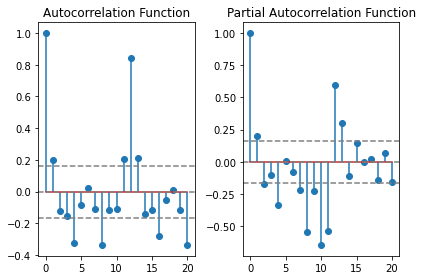

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**PREGUNTAS**


1.   ¿Qué valores de *p* y *q* utilizarías para un primer modelo ARIMA de acuerdo a las representaciones anteriores?



In [ ]:
lag_acf

array([ 1.        ,  0.19975134, -0.12010433, -0.15077204, -0.32207432,
       -0.08397453,  0.02577843, -0.11096075, -0.33672146, -0.11558631,
       -0.10926704,  0.20585223,  0.84142998,  0.21508704, -0.13955394,
       -0.11599576, -0.27894284, -0.05170646,  0.01245814, -0.1143576 ,
       -0.33717439])

In [ ]:
lag_pacf

array([ 1.        ,  0.20081508, -0.17368194, -0.09901213, -0.33527437,
        0.00872185, -0.07990745, -0.21923579, -0.5421352 , -0.22848913,
       -0.64775301, -0.53828661,  0.59971786,  0.29995642, -0.10992268,
        0.14878637, -0.00321881,  0.01892684, -0.14268478,  0.07089814,
       -0.15566902])

Los primeros valores de ambas series sobrepasan el intervalo de confianza, por lo que podemos definir q = p = 1. 

Una vez elegidos los valores de *p* y *q*, podemos utilizar también la derivación interna de la clase ARIMA (*d*) o aplicarlo sobre la serie previamente derivada con valor de *d=0*. 

A continuación, importamos el modelo ARIMA de la siguiente manera. 

Este modelo tiene como argumentos los datos, y el orden: 

model = ARIMA(datos, order = (p,d,q))

In [ ]:
from statsmodels.tsa.arima_model import ARIMA


**PREGUNTAS**


1.   A continuación, completa los valores de p, d y q y utiliza el siguiente código para ajustar un modelo tipo AR. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

2.    Repite el código con los valores de los parámetros correspondientes para ajustar un modelo MA. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

3.    Repite nuevamente el código para combinar los modelos anteriores (ARMA). Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

4.   De acuerdo a los valores de RSS, ¿cuál dirías que es el modelo que mejor se ajusta a los datos?

**RESPUESTA**

1. El modelo AR corresponde a p = 1, q = d = 0.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

Text(0.5, 1.0, 'RSS: nan')

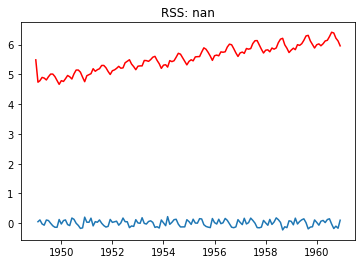

In [ ]:
p = 1
d = 0
q = 0

# AR
model = ARIMA(data_log, order=(p, d, q))  
results_AR = model.fit(disp=-1)  
plt.plot(data_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data_log_diff)**2)) 
# RSS: Residual sum of squares

In [ ]:
def plot_ARIMA(data, results):
  plt.plot(data, label="Data")
  plt.plot(results.fittedvalues, color="red", label="Predicciones")
  plt.legend()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


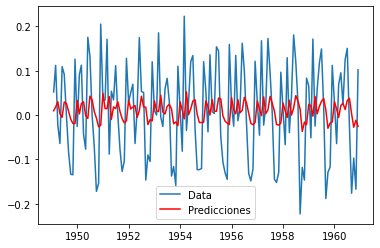

In [ ]:
model = ARIMA(data_log_diff, order=(p, d, q))
results_AR = model.fit()
plot_ARIMA(data_log_diff, results_AR)

Como podemos observar, los datos no se ajustan bien a las predicciones, pues no se tiene en cuenta la media. Además, para el error RSS se imprime "nan".

2. Ajustamos el modelo MA: q = 1, p = d = 0:

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: nan')

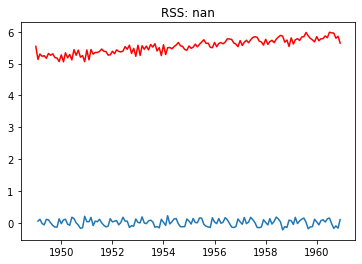

In [ ]:
p = 0
d = 0
q = 1

# AR
model = ARIMA(data_log, order=(p, d, q))  
results_AR = model.fit(disp=-1)  
plt.plot(data_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data_log_diff)**2)) 
# RSS: Residual sum of squares

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


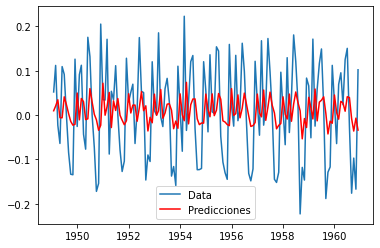

In [ ]:
model = ARIMA(data_log_diff, order=(p, d, q))
results_AR = model.fit()
plot_ARIMA(data_log_diff, results_AR)

De nuevo, los resultados obtenidos no se parecen mucho a los originales. También se imprime un error RSS "nan". 

3. Ahora, para ajustar el modelo ARMA, hacemos p = q = 1, d = 0.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: nan')

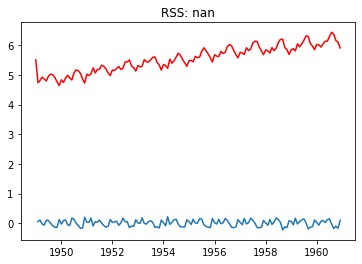

In [ ]:
p = 1
d = 0
q = 1

# AR
model = ARIMA(data_log, order=(p, d, q))  
results_AR = model.fit(disp=-1)  
plt.plot(data_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data_log_diff)**2)) 
# RSS: Residual sum of squares

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


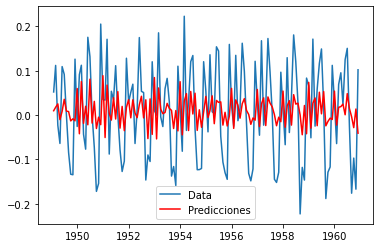

In [ ]:
model = ARIMA(data_log_diff, order=(p, d, q))
results_AR = model.fit()
plot_ARIMA(data_log_diff, results_AR)

A medida que hacemos un modelo más complejo, parece que las predicciones se parecen más a los datos originales, pero seguimos sin tener unos resultados buenos. El error RSS es también "nan". 

4. En los 3 modelos se ha obtenido un error RSS nan, por lo que la única manera que tenemos de comparar los modelos para estudiar cuál de ellos es mejor es la forma gráfica. En este caso, el mejor modelo es el ARMA, aunque sigue sin ser el deseado.

Por último, para predecir valores en el espacio original, tenemos que deshacer las transformaciones realizadas hasta el momento. 

Primero, tomamos los valores ajustados por el modelo (predicciones) y los guardamos como serie temporal. 

Estos valores empiezan en el segundo mes, puesto que hemos tomado diferencias (derivada) de orden 1.

In [ ]:
# Predicciones en el espacio original
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())


Month
1949-02-01    0.009800
1949-03-01    0.017618
1949-04-01    0.025229
1949-05-01   -0.010225
1949-06-01    0.008528
dtype: float64


Segundo, deshacemos la operación de diferencias (en escala logarítmica), con una suma acumulativa y añadiéndoles el valor "base" (primer elemento de la serie). 

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009800
1949-03-01    0.027418
1949-04-01    0.052648
1949-05-01    0.042422
1949-06-01    0.050950
dtype: float64


In [ ]:
predictions_ARIMA_log = pd.Series(data_log[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.728299
1949-03-01    4.745917
1949-04-01    4.771146
1949-05-01    4.760921
dtype: float64


Finalmente, aplicamos la función exponencial (inversa del logaritmo).

Podemos calcular el error cuadrático medio en el espacio original. 

Text(0.5, 1.0, 'RMSE: 52.4891')

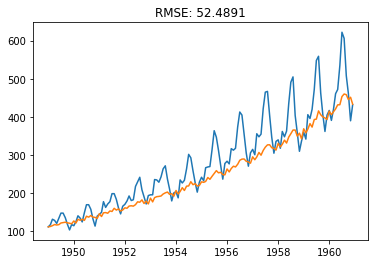

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

Ahora, se ha obtenido el error RMSE en el espacio original en lugar del espacio transformado. Se obtiene un error de 52.4891, que es un error alto, aunque se puede observar como se sigue la tendencia de la serie. 

# 2. Aplicación a otros datos: Acciones en bolsa S&P 500 stock data


Vamos a cargar ahora los datos sobre las acciones en bolsa del fichero *stocks_1yr.csv*:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving stocks_1yr.csv to stocks_1yr.csv


Esta base de datos contiene los datos para las acciones (*stocks*) de un año, y por columnas, contiene los siguientes campos: 


* Date - en formato: yy-mm-dd

* Open - precio de la acción en la apertura de la bolsa

* High - precio más alto alcanzado en el día

* Low Close - precio más bajo en el día

* Volume - Número de acciones vendidas/compradas

* Name - Nombre de la compañía

In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
data = read_csv('stocks_1yr.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(data.head())

             open   high    low  close    volume Name
date                                                 
2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


<ipython-input-43-a2b4ced545d9>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


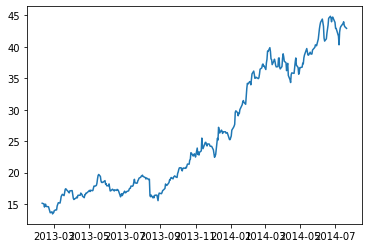

In [ ]:
from matplotlib import pyplot as plt
plt.plot(data.high)

**PREGUNTAS**

Utilizando las herramientas del apartado 1, realiza el análisis de esta serie (puedes utilizar un intervalo de ella o la serie completa). 

En concreto:
1.   Analiza la estacionariedad de esta serie. 
2.   ¿Qué transformaciones puedes realizar para hacerla más estacionaria? Prueba algunas y justifica si consigues una serie más estacionaria. 
3.   Ajusta un modelo ARIMA, y calcula el error de predicción. 



1. Estudiamos la serie data.high, correspondiente al precio más alto alcanzado durante el día. Si se quisiesen analizar otros intervalos, el análisis en análogo a este.

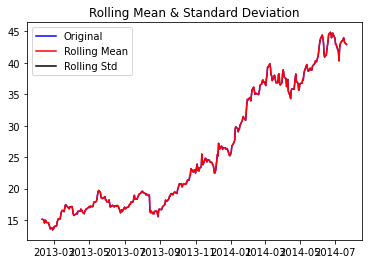

Results of Dickey-Fuller Test:
Test Statistic                   0.239126
p-value                          0.974373
#Lags Used                       3.000000
Number of Observations Used    360.000000
Critical Value (1%)             -3.448646
Critical Value (5%)             -2.869602
Critical Value (10%)            -2.571065
dtype: float64


In [ ]:
test_stationarity(data.high, window_size = 1)

Tras realizar el test de Dickey-Fuller o incluso observando el gráfico, podemos confirmar que la serie no es estacionaria. Además, como podemos observar que la serie no tiene a priori ningún tipo de estacionalidad, usamos un tamaño de ventana unitario.

2. Para hacer la serie más estacionaria, podemos estudiar el comportamiento de la derivada, o incluso la derivada del logaritmo de la serie, que es lo que haremos a continuación.

Results of Dickey-Fuller Test:
Test Statistic                -1.179631e+01
p-value                        9.560899e-22
#Lags Used                     2.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (1%)           -3.448646e+00
Critical Value (5%)           -2.869602e+00
Critical Value (10%)          -2.571065e+00
dtype: float64
None


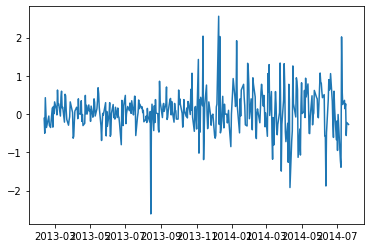

In [ ]:
data_diff_high = (data.high - data.high.shift()).dropna()
plt.plot(data_diff_high)  
print(test_stationarity_2(data_diff_high))

También podemos diferenciar el logaritmo de la función. 

Results of Dickey-Fuller Test:
Test Statistic                -1.754962e+01
p-value                        4.148924e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.620000e+02
Critical Value (1%)           -3.448544e+00
Critical Value (5%)           -2.869557e+00
Critical Value (10%)          -2.571041e+00
dtype: float64
None


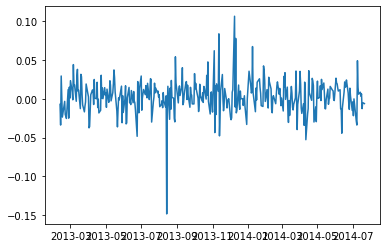

In [ ]:
data_diff_high_log = (np.log(data.high) - np.log(data.high).shift()).dropna()
plt.plot(data_diff_high_log)  
print(test_stationarity_2(data_diff_high_log))

Podemos emplear otro métodos como segundas derivadas o estudiar la raíz cuadrada de la serie, pero como podemos observar tanto por el test como por las gráficas, los resultados obtenidos son estacionarios.

3. Ahora, ajustaremos un modelo ARIMA:

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

Text(0.5, 1.0, 'RSS: 0.1660')

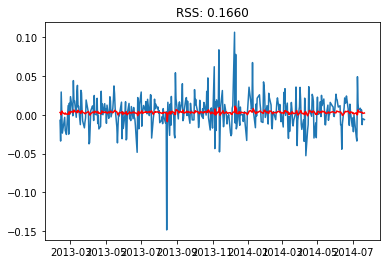

In [ ]:
p = 1
d = 0
q = 1

data_high_log = np.log(data.high).dropna()
data_diff_high_log = (np.log(data.high) - np.log(data.high).shift()).dropna()

# AR
model = ARIMA(data_diff_high_log, order=(p, d, q))  
results_AR = model.fit(disp=-1)  
plt.plot(data_diff_high_log)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data_diff_high_log)**2)) 
# RSS: Residual sum of squares

El error RSS obtenido es de 112.6616, donde hemos usado la derivada del logaritmo de la serie original. Como se puede observar, pese a que la media esté centrada en el origen, existen unos picos muy pronunciados debido a la naturaleza de los propios datos.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


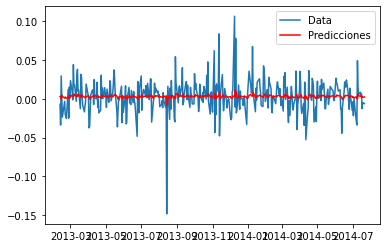

In [ ]:
model = ARIMA(data_diff_high_log, order=(p, d, q))
results_AR = model.fit()
plot_ARIMA(data_diff_high_log, results_AR)

In [ ]:
# Predicciones en el espacio original
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2013-02-11    0.002871
2013-02-12    0.002077
2013-02-13   -0.000032
2013-02-14    0.004732
2013-02-15    0.002869
dtype: float64


In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2013-02-11    0.002871
2013-02-12    0.004948
2013-02-13    0.004915
2013-02-14    0.009647
2013-02-15    0.012516
dtype: float64


In [ ]:
predictions_ARIMA_log = pd.Series(data_high_log[0], index=data_high_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

date
2013-02-08    2.716018
2013-02-11    2.718889
2013-02-12    2.720966
2013-02-13    2.720933
2013-02-14    2.725665
dtype: float64


Text(0.5, 1.0, 'RMSE: 2.7118')

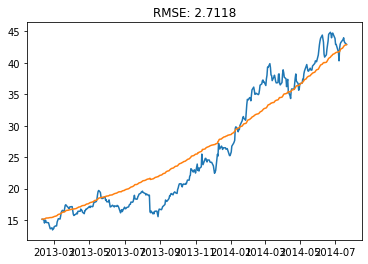

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data.high)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data.high)**2)/len(data.high)))

Para este conjunto de datos, se han realizado las mismas operaciones que se han realizado para el conjunto de datos anterior. Para el empleo del modelo ARIMA, se ha estudiado la derivada del logaritmo de los datos. Luego, mediante cumsum se ha eliminado la influencia de la derivada y mediante la exponencial se ha eliminado la del logaritmo.

Como se puede observar, las predicciones siguen la tendencia pero tienen una varianza menor a los datos originales, los cuales parecen tener un comportamiento estocástico.

En las siguientes celdas, se estudiarán las funciones de autocorrelación y autocorrelación parcial para comprobar que los coeficientes p y q usados son correctos.

Text(0.5, 1.0, 'Partial Autocorrelation Function')

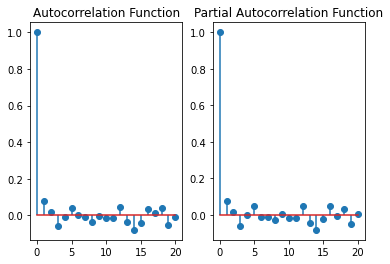

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(data_diff_high_log, nlags=20, fft=False)
lag_pacf = pacf(data_diff_high_log, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.title('Partial Autocorrelation Function')

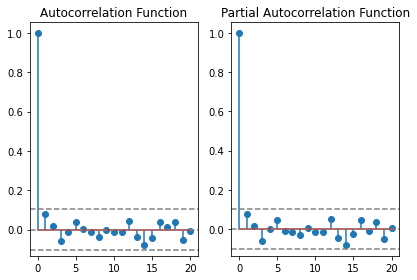

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_diff_high_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_diff_high_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_diff_high_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_diff_high_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Esto implica p = q = 1